In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
from pytz import all_timezones

In [2]:
# Pandas dataframe from pandora data
npz = np.load('PandoraALTZ.npz',allow_pickle=True)
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [3]:
# Filtered data by qflag 0,10
options = [0,10] 
rslt_df = df[df['qflag'].isin(options)] 
#localization of dataframe so that datetime is UTC and not naive
dtimeutc=rslt_df.dtime.dt.tz_localize('Etc/UTC')
dtimelocal=dtimeutc.dt.tz_convert('Etc/GMT+6')
dflocal = rslt_df.assign(dtime=dtimelocal)
tslocal = dflocal.set_index('dtime')
### changing dobson units
tsloc_molcm2=tslocal.assign(ozone=tslocal.ozone*2.6868e16)
## grouping by hour
tslocmean = tsloc_molcm2.ozone.groupby(tslocal.index.hour).mean()
tslocstd=tsloc_molcm2.ozone.groupby(tslocal.index.hour).std()
## grouping by month
tslocmeanmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).mean()
tslocstdmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).std()


In [6]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
#testcount = 0
for year in years:
    merrapath = 'D:\\CCA\\PANDONIA\\O3fromMERRA2\\'+'%i*\\' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdf = pd.read_csv(filename)
        tempdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        
        ############################ converting pressure to altitude
        tdfa = tempdf[tempdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(tempdf.modelP/226.32))/0.000157))
        tdfb = tempdf[tempdf['modelP'] > 226.32].assign(modelP=((1-(tempdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
        tempdf2=tdfa.append(tdfb)
        tempdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
        
        ############################ altitude difference series
        altdiff=tempdf2.modelAlt.diff()
        altdiff=altdiff.replace(altdiff[0],altdiff[1])
        altdiff=-altdiff
        
        ############################ converting altitude to T in degC
        tdfa = tempdf2[tempdf2['modelAlt'] <= 11000].assign(modelAlt=(15.04-0.00649*tempdf2.modelAlt))
        tdfb = tempdf2[tempdf2['modelAlt'] > 11000].assign(modelAlt=-56.46)
        tempdf3=tdfb.append(tdfa)
        tempdf3.set_axis(['fixedP','fixedO3','modelT','modelO3'], axis=1, inplace=True)
        
        ############################ calculating air number density and ozone number density
        nair = tempdf.modelP*100*6.022e23/(8.314463*(tempdf3.modelT+273.15))
        tempdf4 = tempdf2.assign(modelO3=tempdf3.modelO3*nair)
        
        ############################ calculating total column density
        columnO3=(tempdf4.modelO3*altdiff).sum()/10000
        
        ############################ extracting datetime from filename
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
merradf = pd.DataFrame(data={"date": date, "ozone": O3})


In [15]:
tsmerra = merradf.set_index('date')
tsmerrameanmt = tsmerra.ozone.groupby(tsmerra.index.month).mean()
tsmerramm = tsmerra.ozone.resample('M').mean()
tsmerramm2 = tsmerramm.groupby(tsmerramm.index.month).mean()
tsmerrastdmt = tsmerra.ozone.groupby(tsmerra.index.month).std()
tsmerrast = tsmerra.ozone.resample('M').std()
tsmerrast2 = tsmerrast.groupby(tsmerrast.index.month).std()

In [ ]:
## simple plotting with error
ax = tslocmeanmt.plot(figsize=(10,6),title='Ozone yearly profile',ylabel='molecule/cm$^2$',yerr=tslocstdmt,capsize=4,fontsize=12)
tsmerramm2.plot(figsize=(10,6),xlabel='Month',yerr=tsmerrastdmt,capsize=4,fontsize=12)

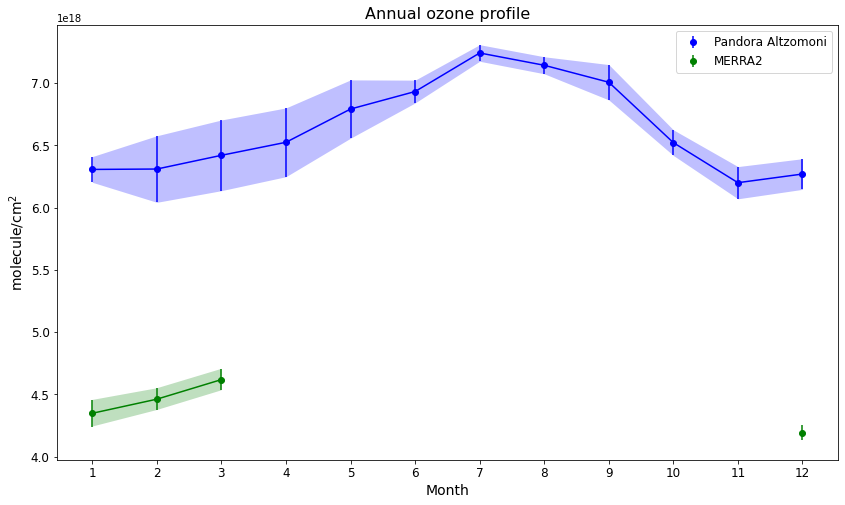

In [46]:
##pyplot plotting
x = tslocmeanmt.index
y1 = tslocmeanmt
err1 = tslocstdmt
y2 = tsmerramm2
err2 = tsmerrast2
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(x, y1, '-b')
ax1.fill_between(x, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
ax1.plot(x, y2, '-g')
ax1.fill_between(x, y2-err2, y2+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax1.errorbar(x, y1, yerr=err1, fmt='bo', label='Pandora Altzomoni')
ax1.errorbar(x, y2, yerr=err2, fmt='go', label='MERRA2')
ax1.set_xticks(np.arange(1,13))
ax1.set_xlabel('Month',size=14)
ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_title("Annual ozone profile",size=16)
ax1.legend(fontsize=12)
ax1.tick_params(labelsize=12)
plt.savefig('D:\\CCA\\PANDONIA\\annualO3PanMERRA.png')

In [ ]:
################## TESTING AFTER THIS LINE

In [43]:
dtimelocal

562            2019-02-01 09:39:56-06:00
563            2019-02-01 09:41:21-06:00
564            2019-02-01 09:42:48-06:00
565            2019-02-01 09:44:12-06:00
566            2019-02-01 09:45:38-06:00
                      ...               
45825   2021-05-25 11:08:18.600000-06:00
45827   2021-05-25 11:18:07.400000-06:00
45830   2021-05-25 11:32:50.400000-06:00
45832   2021-05-25 11:50:55.700000-06:00
45834   2021-05-25 12:02:22.300000-06:00
Name: dtime, Length: 28961, dtype: datetime64[ns, Etc/GMT+6]

In [44]:
dtimeutc

562            2019-02-01 15:39:56+00:00
563            2019-02-01 15:41:21+00:00
564            2019-02-01 15:42:48+00:00
565            2019-02-01 15:44:12+00:00
566            2019-02-01 15:45:38+00:00
                      ...               
45825   2021-05-25 17:08:18.600000+00:00
45827   2021-05-25 17:18:07.400000+00:00
45830   2021-05-25 17:32:50.400000+00:00
45832   2021-05-25 17:50:55.700000+00:00
45834   2021-05-25 18:02:22.300000+00:00
Name: dtime, Length: 28961, dtype: datetime64[ns, Etc/UTC]